# Skew-T Log-P Plotting

This notebook provides a method for grabbing archived soundings and plotting them with parameters.

In [245]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from datetime import datetime

import metpy.calc as mpcalc
from metpy.plots import SkewT, Hodograph
from metpy.units import units

### Sounding to be Plotted

In [246]:
#Date
year = 2011
month = 4
day = 27
hour = 18

#Station
station = "KJAN"

dt = datetime(year=year,month=month,day=day,hour=hour)

### Download Sounding from Iowa Environmental Mesonet

In [247]:
#https://mesonet.agron.iastate.edu/json/raob.py?ts=199305031200&station=KOUN
ts = dt.strftime('%Y%m%d%H%M')

url = f"https://mesonet.agron.iastate.edu/json/raob.py?ts={ts}&station={station}"
json = pd.read_json(url)

df = pd.json_normalize(json.profiles[0],'profile',['station','valid'])
df['valid'] = pd.to_datetime(df['valid'])
xr = df.to_xarray()

#add units
xr['pres'] = xr['pres'] * units.hPa
xr['hght'] = xr['hght'] * units('meters')
xr['tmpc'] = xr['tmpc'] * units('degC')
xr['dwpc'] = xr['dwpc'] * units('degC')
xr['drct'] = xr['drct'] * units('degrees')
xr['sknt'] = xr['sknt'] * units('knots')

temp_inds = np.intersect1d(xr.tmpc.dropna(dim='index').index,xr.dwpc.dropna(dim='index').index)

p = xr.pres[temp_inds].to_numpy() * units.hPa
t = xr.tmpc[temp_inds].to_numpy() * units.degC
td = xr.dwpc[temp_inds].to_numpy() * units.degC

In [248]:
sb_cape, sb_cin = mpcalc.surface_based_cape_cin(p,t,td)
ml_cape, ml_cin = mpcalc.mixed_layer_cape_cin(p,t,td)
mu_cape, mu_cin = mpcalc.most_unstable_cape_cin(p,t,td)

lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], t[0], td[0])
lfc_pressure, lfc_temperature = mpcalc.lfc(p,t,td)
lcl_hgt = mpcalc.pressure_to_height_std(lcl_pressure).to(units.meter)
lfc_hgt = mpcalc.pressure_to_height_std(lfc_pressure).to(units.meter)

print(lcl_hgt)
print(lfc_hgt)

914.3831063021958 meter
937.8644999262847 meter


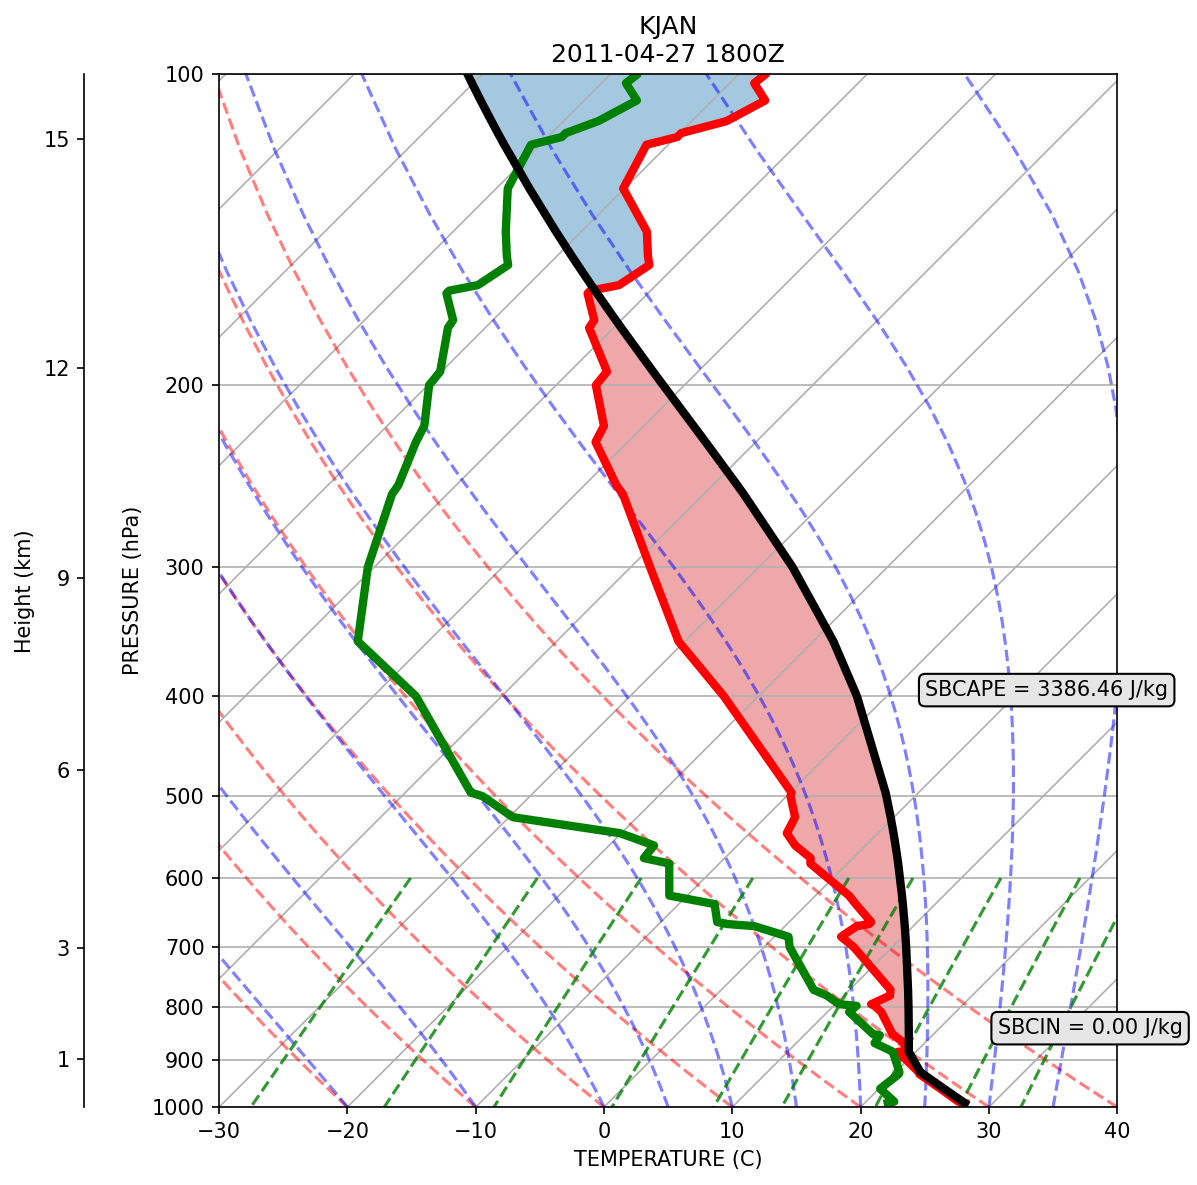

In [249]:
fig = plt.figure(figsize=(11, 8), dpi=150,facecolor='w')
gs = gridspec.GridSpec(3, 3)
skew = SkewT(fig, rotation=45, subplot=gs[:,:2])
#skew = SkewT(fig,subplot=(1,2,1),rotation=45)

p = xr.pres[temp_inds].to_numpy() * units.hPa
t = xr.tmpc[temp_inds].to_numpy() * units.degC
td = xr.dwpc[temp_inds].to_numpy() * units.degC

parcel = mpcalc.parcel_profile(p, t[0], td[0]).to('degC')

skew.plot(p, t, 'r',lw=4)
skew.plot(p, td, 'g',lw=4)
skew.plot(p,parcel,'k',lw=4)

skew.shade_cin(p, t, parcel)
skew.shade_cape(p, t, parcel)

skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-30,40)

plt.xlabel('TEMPERATURE (C)')
plt.ylabel('PRESSURE (hPa)')

plt.yticks([1000,900,800,700,600,500,400,300,200,100])
secy = skew.ax.secondary_yaxis(-0.15,functions=(
        lambda p: mpcalc.pressure_to_height_std(units.Quantity(p, 'hPa')).m_as('km'),
        lambda h: mpcalc.height_to_pressure_std(units.Quantity(h, 'km')).m
    ))
secy.yaxis.set_major_locator(plt.FixedLocator([0, 1, 3, 6, 9, 12, 15]))
secy.yaxis.set_minor_locator(plt.NullLocator())
secy.yaxis.set_major_formatter(plt.ScalarFormatter())
secy.set_ylabel('Height (km)')


time = str(xr.valid[0].values)
time = datetime.strptime(time[:19],'%Y-%m-%d %H:%M:%S')

skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

plt.title(f"{xr.station[0].values}\n"+time.strftime('%Y-%m-%d %H%MZ'))

plt.annotate(f'SBCAPE = {sb_cape.magnitude:0.2f} J/kg',[-7,400],bbox=dict(boxstyle="round", fc="0.9"))
plt.annotate(f'SBCIN = {sb_cin.magnitude:0.2f} J/kg',[25,850],bbox=dict(boxstyle="round", fc="0.9"))


fig.tight_layout()
plt.savefig(f"{xr.station[0].values}_"+time.strftime('%Y%m%d_%H%MZ')+".png",bbox_inches='tight')

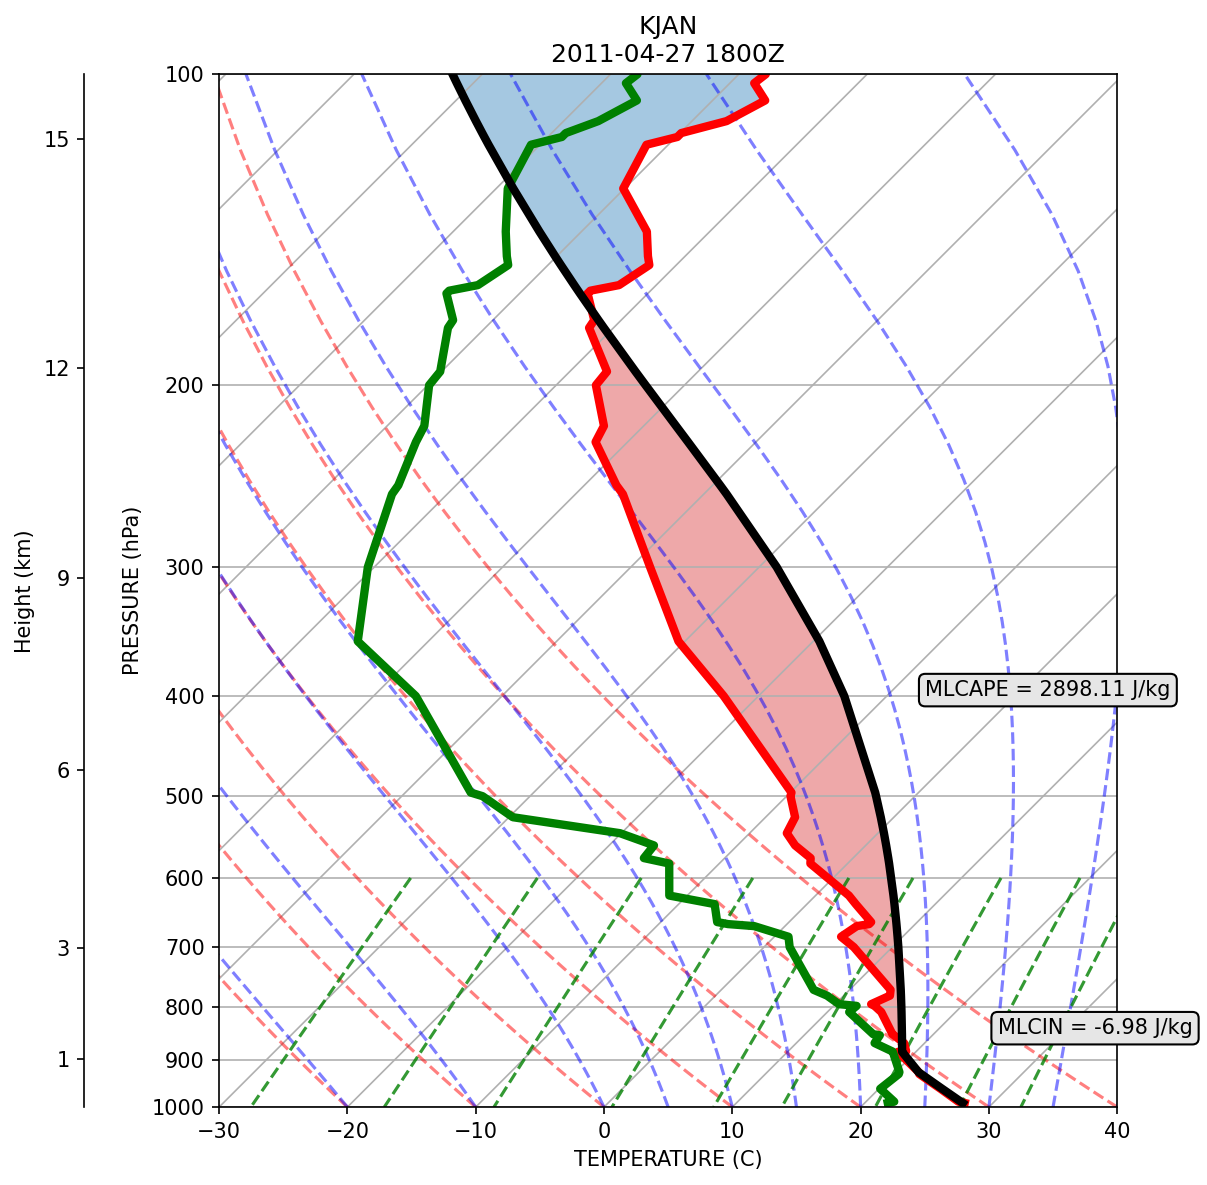

In [250]:
fig = plt.figure(figsize=(11, 8), dpi=150,facecolor='w')
gs = gridspec.GridSpec(3, 3)
skew = SkewT(fig, rotation=45, subplot=gs[:,:2])
#skew = SkewT(fig,subplot=(1,2,1),rotation=45)

p = xr.pres[temp_inds].to_numpy() * units.hPa
t = xr.tmpc[temp_inds].to_numpy() * units.degC
td = xr.dwpc[temp_inds].to_numpy() * units.degC

null,mp_t,mp_td = mpcalc.mixed_parcel(p,t,td)

parcel = mpcalc.parcel_profile(p,mp_t,mp_td).to('degC')

skew.plot(p, t, 'r',lw=4)
skew.plot(p, td, 'g',lw=4)
skew.plot(p,parcel,'k',lw=4)

skew.shade_cin(p, t, parcel)
skew.shade_cape(p, t, parcel)

skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-30,40)

plt.xlabel('TEMPERATURE (C)')
plt.ylabel('PRESSURE (hPa)')

plt.yticks([1000,900,800,700,600,500,400,300,200,100])
secy = skew.ax.secondary_yaxis(-0.15,functions=(
        lambda p: mpcalc.pressure_to_height_std(units.Quantity(p, 'hPa')).m_as('km'),
        lambda h: mpcalc.height_to_pressure_std(units.Quantity(h, 'km')).m
    ))
secy.yaxis.set_major_locator(plt.FixedLocator([0, 1, 3, 6, 9, 12, 15]))
secy.yaxis.set_minor_locator(plt.NullLocator())
secy.yaxis.set_major_formatter(plt.ScalarFormatter())
secy.set_ylabel('Height (km)')


time = str(xr.valid[0].values)
time = datetime.strptime(time[:19],'%Y-%m-%d %H:%M:%S')

skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

plt.title(f"{xr.station[0].values}\n"+time.strftime('%Y-%m-%d %H%MZ'))

plt.annotate(f'MLCAPE = {ml_cape.magnitude:0.2f} J/kg',[-7,400],bbox=dict(boxstyle="round", fc="0.9"))
plt.annotate(f'MLCIN = {ml_cin.magnitude:0.2f} J/kg',[25,850],bbox=dict(boxstyle="round", fc="0.9"))


fig.tight_layout()
plt.savefig(f"{xr.station[0].values}_"+time.strftime('%Y%m%d_%H%MZ')+"_ML.png",bbox_inches='tight')

1


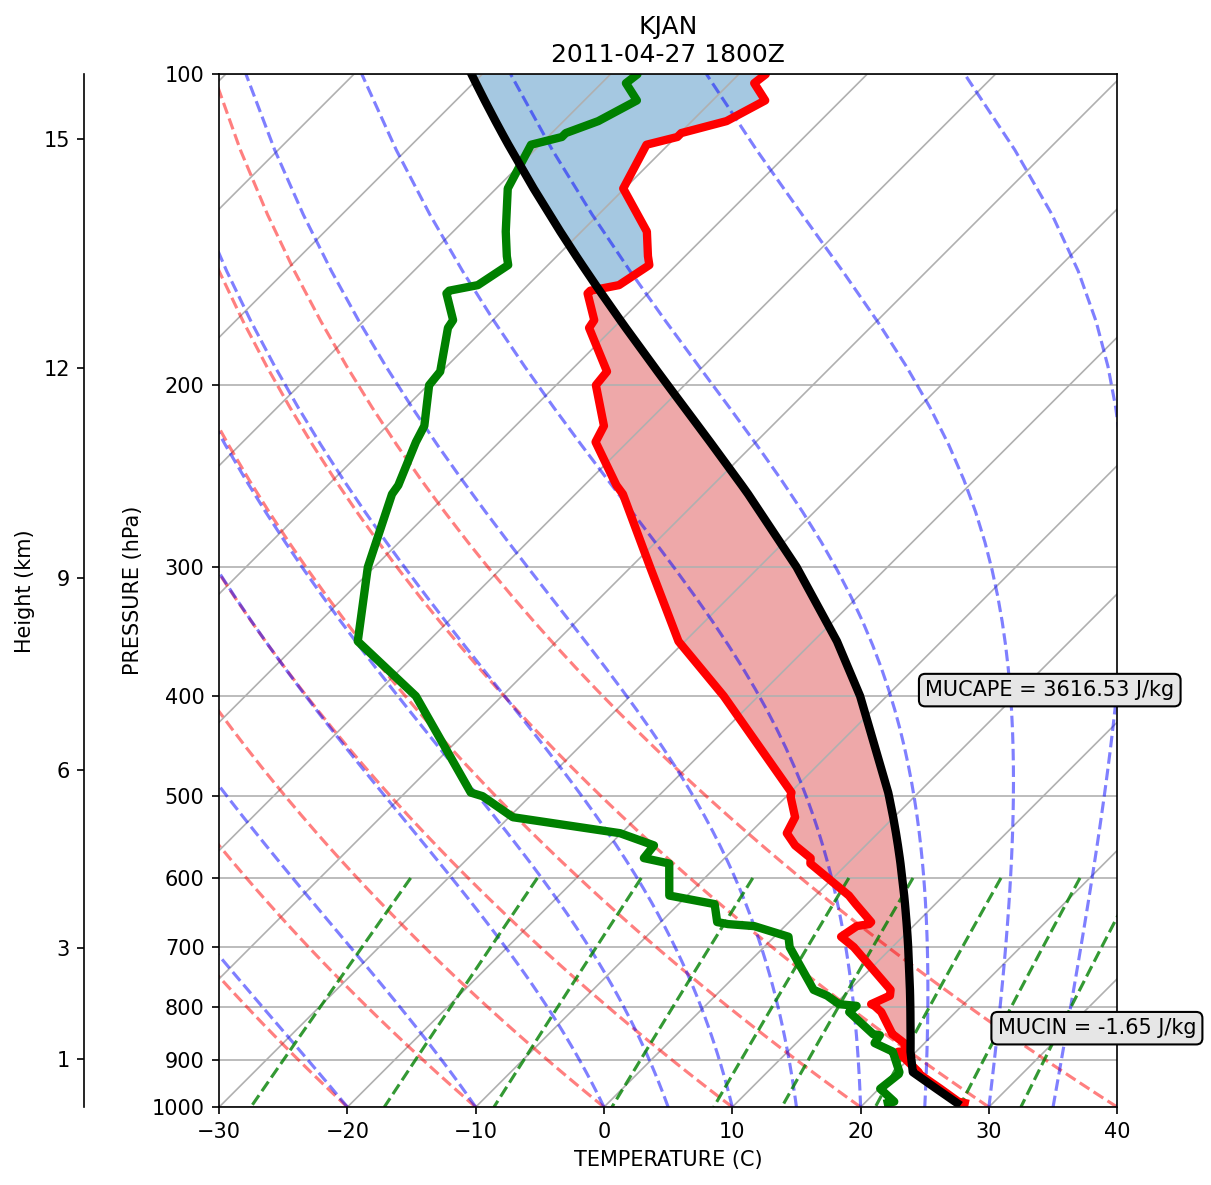

In [251]:
fig = plt.figure(figsize=(11, 8), dpi=150,facecolor='w')
gs = gridspec.GridSpec(3, 3)
skew = SkewT(fig, rotation=45, subplot=gs[:,:2])
#skew = SkewT(fig,subplot=(1,2,1),rotation=45)

p = xr.pres[temp_inds].to_numpy() * units.hPa
t = xr.tmpc[temp_inds].to_numpy() * units.degC
td = xr.dwpc[temp_inds].to_numpy() * units.degC

null,mu_t,mu_td,ind = mpcalc.most_unstable_parcel(p,t,td)
print(ind)

parcel = mpcalc.parcel_profile(p,mu_t,mu_td).to('degC')
parcel[:ind-1]=np.nan

skew.plot(p, t, 'r',lw=4)
skew.plot(p, td, 'g',lw=4)
skew.plot(p,parcel,'k',lw=4)

skew.shade_cin(p, t, parcel)
skew.shade_cape(p, t, parcel)

skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-30,40)

plt.xlabel('TEMPERATURE (C)')
plt.ylabel('PRESSURE (hPa)')

plt.yticks([1000,900,800,700,600,500,400,300,200,100])
secy = skew.ax.secondary_yaxis(-0.15,functions=(
        lambda p: mpcalc.pressure_to_height_std(units.Quantity(p, 'hPa')).m_as('km'),
        lambda h: mpcalc.height_to_pressure_std(units.Quantity(h, 'km')).m
    ))
secy.yaxis.set_major_locator(plt.FixedLocator([0, 1, 3, 6, 9, 12, 15]))
secy.yaxis.set_minor_locator(plt.NullLocator())
secy.yaxis.set_major_formatter(plt.ScalarFormatter())
secy.set_ylabel('Height (km)')


time = str(xr.valid[0].values)
time = datetime.strptime(time[:19],'%Y-%m-%d %H:%M:%S')

skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

plt.title(f"{xr.station[0].values}\n"+time.strftime('%Y-%m-%d %H%MZ'))

plt.annotate(f'MUCAPE = {mu_cape.magnitude:0.2f} J/kg',[-7,400],bbox=dict(boxstyle="round", fc="0.9"))
plt.annotate(f'MUCIN = {mu_cin.magnitude:0.2f} J/kg',[25,850],bbox=dict(boxstyle="round", fc="0.9"))


fig.tight_layout()
plt.savefig(f"{xr.station[0].values}_"+time.strftime('%Y%m%d_%H%MZ')+"_MU.png",bbox_inches='tight')